In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

## Directivity

Maximum amplitude received by a ring of listeners placed around the object of study.

Objects:

- DipoleSource
- LineArray
- SmartSpeaker

In [4]:
from src.core import Domain2D
from src.solvers import Wave
from src.utils import builders
from src.experiments import DirectivityExperiment
from src.components import DipoleSource, RickerSource

# 1. Prepare the Lab (Domain)
room = Domain2D(length=[10, 10], dx=0.05, material=0.0)

# 2. Build the Device Under Test (DUT)

# Example A: A Line Array
# builders.build_line_array(room, center=room.L/2.0, num_elements=5, spacing=0.2, frequency=343)

# Example B: A Dipole Source
# room.add_source(DipoleSource(pos=[5,5], frequency=343, orientation=90.0))

# Example C: A Speaker Box
builders.build_smart_speaker(room, center=room.L/2.0, width=1.0, height=0.6)
room.add_source(RickerSource(pos=room.L/2.0, frequency=100, delay=0.005))

   Deployed 72 microphones at r=2.0m.


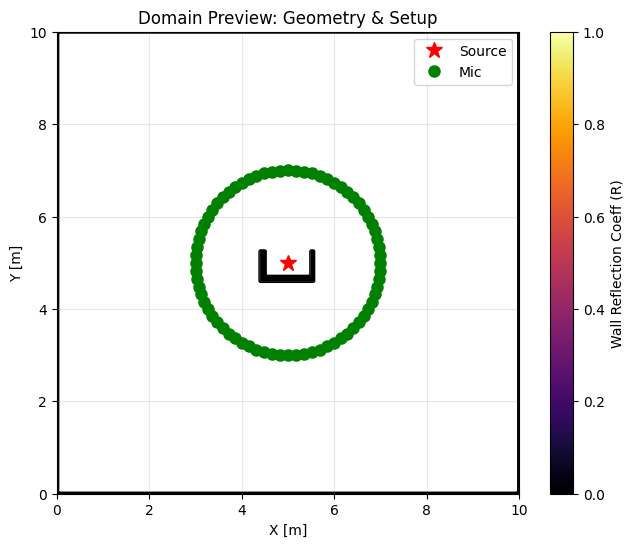

🧪 Starting Experiment: DirectivityExperiment
Auto-switching to 'robin' boundaries (Absorption detected in Domain).
   Simulating 0.050s (489 steps)...
✅ Experiment Complete.


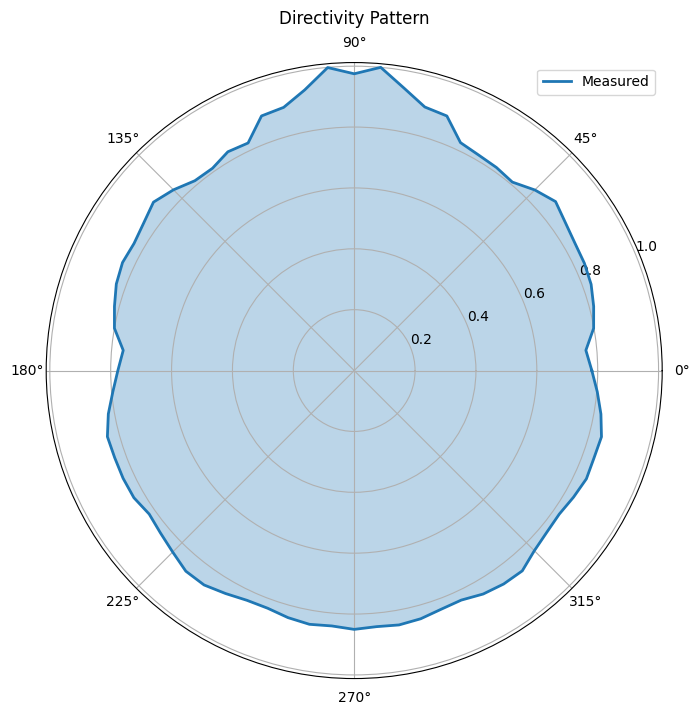

In [3]:
# 3. Setup and Run the Experiment
lab = DirectivityExperiment(
    domain=room, 
    solver_class=Wave,
    radius=2.0,
    c=343.0
)

lab.setup() # Deploys microphones
lab.domain.preview() # Visualizes the setup

lab.run(duration=0.05) # Runs physics
lab.plot() # Shows the graph

## Impulse Response of a Room

Get Signal and Frequency Response at a given point in the Domain with an arbitrary device.

   Microphone placed at [5, 7.5]


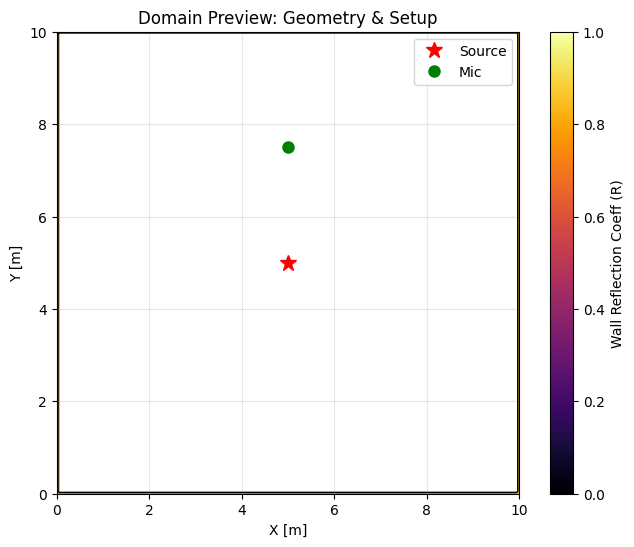

🧪 Starting Experiment: ImpulseResponseExperiment
Auto-switching to 'robin' boundaries (Absorption detected in Domain).
   Simulating 0.100s (979 steps)...
✅ Experiment Complete.


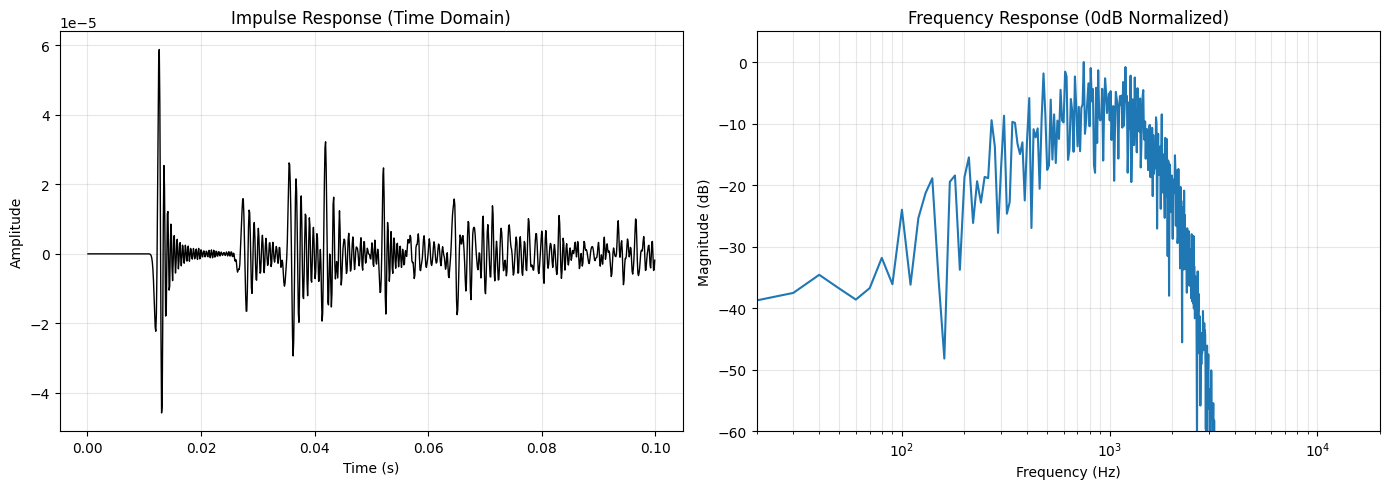

In [4]:
from src.core import Domain2D
from src.solvers import Wave
from src.utils import builders
from src.experiments import ImpulseResponseExperiment
from src.components import RickerSource

# 1. Prepare the Lab
# Material=0.8 means slightly absorbent walls (realistic room)
room = Domain2D(length=[10, 10], dx=0.05, material=0.8)

# 2. Build Device Under Test
# builders.build_smart_speaker(room, center=[5, 5], width=1.0, height=0.6)
room.add_source(RickerSource(pos=room.L/2.0, frequency=1000, delay=0.005))

# 4. Setup Experiment
# We place the mic 2 meters in front of the speaker
lab = ImpulseResponseExperiment(
    domain=room, 
    solver_class=Wave,
    measure_pos=[5, 7.5], 
    c=343.0
)

lab.setup()
lab.domain.preview()

# 5. Run
# Run long enough for reflections to bounce around (0.1s is usually enough for small rooms)
lab.run(duration=0.1) 

# 6. Analyze
lab.plot()

## Double Slit

Generate a plane wave with a line array and place a double slit in the middle of the room.
Add listeners on the other side of the slit to capture patterns.

✅ Double Slit built at x=5.0 (Sep: 1.0m, Width: 0.2m)


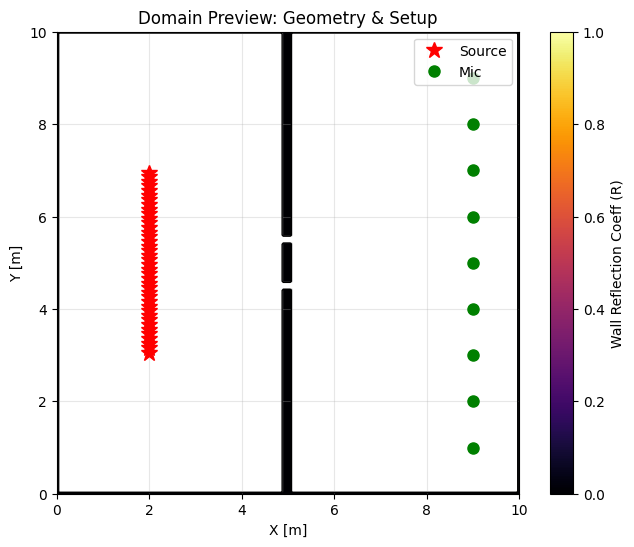

In [5]:
from src.core import Domain2D
from src.solvers import Wave
from src.components import Listener
from src.utils import builders
from src.visualization import PhysicsAnimator

# 1. Setup the "Lab"
# material=0.0 (Anechoic) ensures we only see direct interference, not room reflections
room = Domain2D(length=[10, 10], dx=0.05, material=0.0)

# 2. Build Double Slit Barrier
# Barrier at x=5.0m
# Slits separated by 1.0m (roughly 3 wavelengths at 1000Hz)
builders.build_double_slit(
    room, 
    wall_x=5.0, 
    slit_width=0.2, 
    slit_separation=1.0, 
    wall_thickness=0.2
)

# 3. Add Source (Plane Wave Generator)
# We build a vertical line array on the far left to send a wall of sound
builders.build_line_array(
    room, 
    center=[2.0, 5.0],    # 3 meters behind the wall
    num_elements=40,      # Dense array for smooth wavefront
    spacing=0.1, 
    frequency=1000.0,     # High enough freq to see fringes
    axis='y'
)

# 4. Add listeners on the other side
for y in range(1, 10):
    room.add_listener(Listener(pos=[9.0, y], tag='y')) # 3 meters beyond the wall

room.preview()

In [ ]:
# 5. Run Physics
solver = Wave(domain=room, c=343.0)
animator = PhysicsAnimator(solver, total_time=0.05) # Just enough to pass through
animator.run()

# 6. Visualize
# We enable aggressive spatial downsampling to make the plot light
fig = animator.create_animation(skip_frames=1, skip_spatial=2)
fig.show()

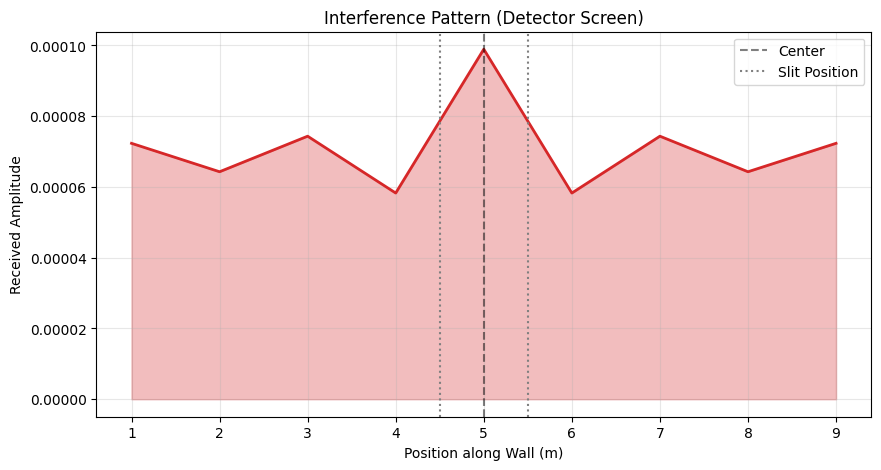

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def plot_interference_pattern(listeners):
    # 1. Harvest Data
    y_positions = []
    max_amplitudes = []
    
    for l in listeners:
        y_positions.append(l.pos[1]) # Y-coordinate
        
        # Extract signal energy or peak amplitude
        times, signal = l.get_time_series()
        
        # Take the steady state (last 50% of simulation) to avoid startup transients
        steady_signal = signal[int(len(signal)*0.5):]
        if len(steady_signal) == 0: steady_signal = signal
            
        max_amplitudes.append(np.max(np.abs(steady_signal)))
        
    # 2. Sort Data (Crucial for clean line plotting)
    # If listeners weren't added in perfect Y-order, the line would zigzag.
    data = sorted(zip(y_positions, max_amplitudes))
    y_sorted, amp_sorted = zip(*data)
    
    # 3. Plot
    plt.figure(figsize=(10, 5))
    
    # We plot Y on the x-axis to match the "Screen" perspective
    plt.plot(y_sorted, amp_sorted, color='tab:red', lw=2)
    plt.fill_between(y_sorted, amp_sorted, color='tab:red', alpha=0.3)
    
    # Add markers for the slits (visual reference)
    # Assuming standard setup centered at 5.0 with 1.0m separation
    plt.axvline(x=5.0, color='black', linestyle='--', alpha=0.5, label='Center')
    plt.axvline(x=5.5, color='gray', linestyle=':', label='Slit Position')
    plt.axvline(x=4.5, color='gray', linestyle=':')
    
    plt.title("Interference Pattern (Detector Screen)")
    plt.xlabel("Position along Wall (m)")
    plt.ylabel("Received Amplitude")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Run visualization
plot_interference_pattern(solver.domain.listeners)

### Whispering Gallery

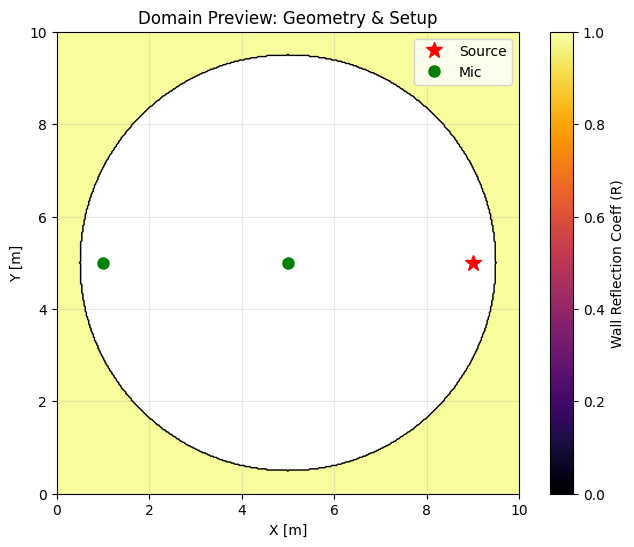

In [10]:
from src.core import Domain2D
from src.solvers import Wave
from src.visualization import PhysicsAnimator
from src.components import RickerSource, Listener
import numpy as np

# 1. Setup the Gallery
room = Domain2D(length=[10, 10], dx=0.025, material=0.99) # Hard walls
room.add_circular_cavity(pos=[5, 5], radius=4.5)

# 2. Add Source near wall
room.add_source(RickerSource(
    pos=[9.0, 5.0], 
    frequency=400, 
    delay=0.01,
    amplitude=5.0
))

# 3. Add Listeners
room.add_listener(Listener(pos=[5, 5], tag="Center"))
room.add_listener(Listener(pos=[1.0, 5.0], tag="Opposite"))
    
room.preview()

In [11]:
# --- THE FIX ---
# Calculate a "Safe" dt manually
# Standard limit is 1.0. We use 0.5 to be safe around the curved stairs.
c = 343.0
safe_dt = 0.2 * (room.ds[0] / c) 

print(f"⚠️ Enforcing Safe CFL=0.5 (dt={safe_dt:.6f}s)")

# 4. Run Physics with manual dt
solver = Wave(domain=room, c=c, dt=safe_dt)
animator = PhysicsAnimator(solver, total_time=0.15) 
animator.run()

# 5. Visualize
fig = animator.create_animation(skip_frames=5, skip_spatial=2)
fig.show()

⚠️ Enforcing Safe CFL=0.5 (dt=0.000015s)
Auto-switching to 'robin' boundaries (Absorption detected in Domain).
Simulating 0.15s of physics (10289 steps) in 2D...
Simulation complete.
Dynamic Scale Found: [-1.93e+27, 1.75e+27]
Animating 2058 frames (Spatial stride: 2)...
